## Check recording info

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subjects

sess = subjects.nsd.ratNday2[0]
print(sess.recinfo)


filename: /data/Clustering/sessions/RatN/Day2/RatN_Day2_2019-10-11_03-58-54.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250



## Set probe configuration
This animal had 8 shank probe from diagnostic biochips

In [ ]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
for i in range(8):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=20,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shanks.append(shank)
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks)

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save()
plot_probe(prbgrp)



## Create epochs for your experimental paradigm
A typical experiment involves multiple epochs such pre sleep, running on track and then another sleep epoch.

In [2]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 10282, 13863],
        "stop": [10270, 13545, 53581],
        "label": ["pre", "maze", "post"],
    }
)

Epoch(epochs=epochs).save(sess.filePrefix.with_suffix(".paradigm.npy"))

/data/Clustering/sessions/RatN/Day2/RatN_Day2_2019-10-11_03-58-54.paradigm.npy saved


# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
plotting.plot_artifact_epochs(artifact_epochs, signal)


## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Neurons
- import spiketrains from Phy
- estimate neuron types such pyramidal, interneuron etc. 

## Importing spiketrains from Phy

In [ ]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatN/Day2/spykcirc/clus_combined/"
)
chan_grps = sess.recinfo.channel_groups
sub_dirs = sorted([x for x in cluster_path.iterdir() if x.is_dir()])

spk, peak_chans,waveforms,shank_id = [], [],[],[]
for f_ind, folder in enumerate(sub_dirs):
    print(folder)
    phy_data = PhyIO(folder)
    spk.extend(phy_data.spiketrains)
    peak_chans.extend(chan_grps[f_ind][phy_data.peak_channels])
    waveforms.append(phy_data.waveforms)
    shank_id.extend([f_ind]*len(phy_data.spiketrains))

n_channels_waveforms = np.sum([_.shape[1] for _ in waveforms])
n_timepoints_waveforms = phy_data.waveforms.shape[2]
n_neurons = len(spk) 

waveforms_combined = np.zeros((n_neurons,n_channels_waveforms,n_timepoints_waveforms))
row,col=0,0
for w in waveforms:
    waveforms_combined[row:row+w.shape[0],col:col+w.shape[1],:]= w
    row+=w.shape[0]
    col+=w.shape[1]


peak_chans = np.array(peak_chans)

neurons = Neurons(
    np.array(spk, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=waveforms_combined,
    shank_ids=np.array(shank_id),
    neuron_type=sess.neurons.neuron_type,
)
neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()

## Estimate neuron type

In [ ]:
%matplotlib widget
from neuropy.utils import neurons_util
neuron_type = neurons_util.estimate_neuron_type(sess.neurons)
sess.neurons.neuron_type = neuron_type

In [ ]:
neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster

plot_raster(neurons,color='jet',add_vert_jitter=True)

## BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


# Assign position data

In [3]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder,scale_factor=0.25)

/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 03.58.37 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 04.08.48 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 04.10.41 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 07.19.00 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 08.15.29 AM.csv
/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 08.55.22 AM.csv


/data/Clustering/sessions/RatN/Day2/RatN_Day2_2019-10-11_03-58-54.position.npy saved


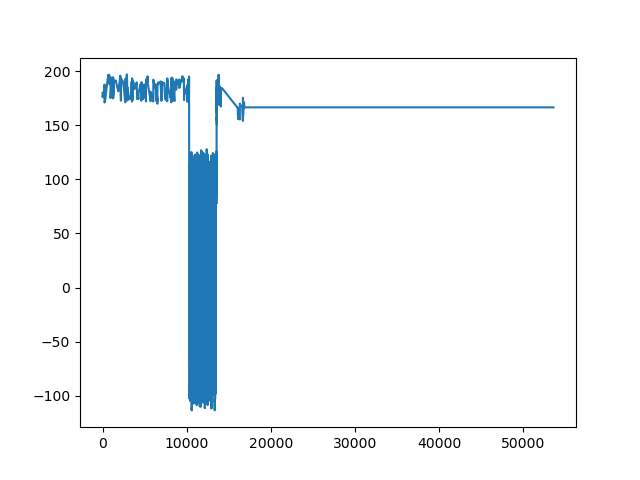

In [5]:
import pandas as pd
from datetime import datetime

# ------- maze align corection ---------
t_error = [0, 1]

# ---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix(".datetime.csv"))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    sync_time = rec_datetime["sync_nframes"][i] / rec_datetime["sync_rate"][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta(
        t_error[i], unit="sec"
    )
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
        inclusive="left",
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

# ------- deleting intervals that were deleted from .dat file after concatenating
ndeletedintervals = rec_datetime.count()["deletedStart (minutes)"]
del_index = []
for i in range(ndeletedintervals):
    tnoisy_begin = int(rec_datetime["deletedStart (minutes)"][i] * 60 * tracking_sRate)
    tnoisy_end = int(rec_datetime["deletedEnd (minutes)"][i] * 60 * tracking_sRate)

    del_index.append(np.arange(tnoisy_begin, tnoisy_end))

del_index = np.concatenate(del_index)
data_time = np.delete(data_time, del_index)

x, y, z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z, x, y))

position = Position(traces=traces, t_start=0, sampling_rate=opti_data.sampling_rate)
position.save(sess.filePrefix.with_suffix(".position.npy"))


_, ax = plt.subplots()
ax.plot(position.time, position.x)


## Linearize position

In [2]:
from neuropy.utils import position_util

maze = sess.paradigm['maze'].flatten()
maze_pos = sess.position.time_slice(maze[0],maze[1])
linear_pos = position_util.linearize_position(maze_pos)
linear_pos.save(sess.filePrefix.with_suffix('.maze.linear'))

/data/Clustering/sessions/RatN/Day2/RatN_Day2_2019-10-11_03-58-54.maze.linear saved


In [ ]:
%matplotlib widget
from neuropy import plotting

fig = plotting.Fig(grid=(2,4),size=(8.5,5))

ax = fig.subplot(fig.gs[0])
ax.plot(maze_pos.x,maze_pos.y)

ax = fig.subplot(fig.gs[0,1:])
ax.plot(maze_pos.time,maze_pos.x,'r')
ax.plot(maze_pos.time,maze_pos.y,'g')
ax.plot(linear_pos.time,linear_pos.x,'gray')